<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/LHMProgram/blob/main/Ana_Alonso_Week2_HW1_txt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q-Learning DQN

 In this homework we will implement DQN for frozen lake environment

## Deep Q-Learning

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

But this is not scalable. Must compute $Q(s,a)$ for every state-action pair. If state is e.g. current game state pixels, computationally infeasible to compute for entire state space! But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}

To minimise this error, we will use the `Huber
loss <https://en.wikipedia.org/wiki/Huber_loss>`__. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}



### Double Deep Q-Learning

We will implement Double Deep Q-Learning here. Double Deep Q-Learning is used to reduce the maximaztion bias in Q-Learning. This entails using two separate $Q$-value estimators, each of which is used to update the other. The target values are calculated using a target Q-network. The target Q-network's parameters are updated to the current networks every $C$ time steps.

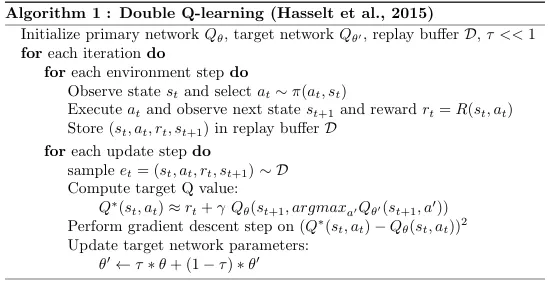

[Image Source](https://towardsdatascience.com/double-deep-q-networks-905dd8325412)

In [24]:
# Import libraries
import numpy as np
import gym
import random

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython.display import clear_output
from IPython import display as ipythondisplay
from IPython import display
import glob
import base64, io, os

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Create the environment
env = gym.make("FrozenLake-v1", is_slippery=False, new_step_api=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Get state and action dimensions
state_dim = env.observation_space.n  # Assuming discrete state space
action_dim = env.action_space.n

In [6]:
# Hyperparameters
num_episodes = 1000          # Total training episodes
lr = 1e-3                    # Learning rat
gamma = 0.99                 # Discounting rate
epsilon = 0.1

In [7]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # Construction of a block of sequential layers 3 linear layers and 2 ReLu activations
        self.layer_block = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    # Forward pass
    def forward(self, x):
        return self.layer_block(x)

In [19]:
class DQLAgent:
    def __init__(self, input_dim, output_dim, lr, gamma, epsilon):
        # Instance variables that store the dimensions
        self.input_dim = input_dim
        self.output_dim = output_dim
        # Main DQN used for action selection and learning
        self.dqn = DQN(input_dim, output_dim).to(device)
        # Target DQN to compute target Q-values during training for more stable updates
        self.target_dqn = DQN(input_dim, output_dim).to(device)

        # Initializing the target with the same weights as the main DQN
        self.target_dqn.load_state_dict(self.dqn.state_dict())

        # The DQN will be updated using the MSELoss and RMSprop optimizer
        self.optimizer = optim.RMSprop(self.dqn.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()
        self.gamma = gamma
        self.epsilon = epsilon

    # Select an action for the agent to take in a given state
    # Implementing epsilon-greedy strategy for action selection in the DQL agent
    def get_action(self, state):
      # checking if a rand number between 0 and 1 is < than the agent's self epsilon (prob)
        if np.random.rand() < self.epsilon:
          # Random action choosen (exploration)
          return np.random.randint(self.output_dim)
        else:
          # The agent will take the knowledge and select the best action based on the current Q-values
          with torch.no_grad():
            # Using the one hot encoding conversion (number to array)
            state = self.one_hot_encode(state)
            # Passing the state through the network
            q_values = self.dqn(state)
            return torch.argmax(q_values).item() # Takes the biggest Q value for this state

    def update(self, state, action, reward, next_state, done):
        # State and next_state into one hot encoding
        state = self.one_hot_encode(state)
        next_state = self.one_hot_encode(next_state)
        # Reward and action to tensor adding an unsqueeze batch of size 1
        reward = torch.tensor(reward).unsqueeze(0).to(device)
        action = torch.tensor(action).unsqueeze(0).to(device)
        done = torch.tensor(done).unsqueeze(0).float().to(device)  # Same but casting to float

        # Q-value of the action in the current state
        current_q = self.dqn(state)[0][action]
        # Max Q-value in the next step using the targat dqn
        max_next_q = self.target_dqn(next_state).max(1)[0]
        # This is the reason why done must be cast into float: Bellman Equation
        target_q = reward + (1 - done) * self.gamma * max_next_q

        # MSE loss between the current Q-value and the target Q-value
        loss = self.loss_fn(current_q, target_q.detach())
        # Updates the weights of the main DQN using RMSprop optimizer
        self.optimizer.zero_grad()
        loss.backward()
        # Updates the model's parameters
        self.optimizer.step()

    # Update the weights of the target DQN matching the main ones, to make them equivalent
    def update_target(self):
        self.target_dqn.load_state_dict(self.dqn.state_dict())

    # Function to convert state into one hot encoding
    def one_hot_encode(self, state):
        state_one_hot = torch.zeros(1, self.input_dim).to(device)
        state_one_hot[0][state] = 1
        return state_one_hot

In [20]:
agent = DQLAgent(input_dim=state_dim, output_dim=action_dim, lr=lr, gamma=gamma, epsilon=epsilon)

In [21]:
# Train the agent
rewards = []
# Trainning loop that iterates over the 1000 episodes
for episode in range(num_episodes):
    # Environment reseting, getting the initial state for each episode
    state = env.reset()
    # Done and total reward inizialitation
    done = False
    total_reward = 0
    # While loop that finishes when an episode is done
    while not done:
        # Agent chooses next action using the epsilon greedy stragety
        action = agent.get_action(state)
        # With the action that has been selected, the environment
        # returns the next state, the reward and closes the episode
        next_state, reward, done, _, _ = env.step(action)
        # Update the DQN with the transition
        agent.update(state, action, reward, next_state, done)
        # Update the state
        state = next_state
        total_reward += reward

    # Append the total reward for each episode
    rewards.append(total_reward)
    # Update target network every time an episode finishes
    agent.update_target()

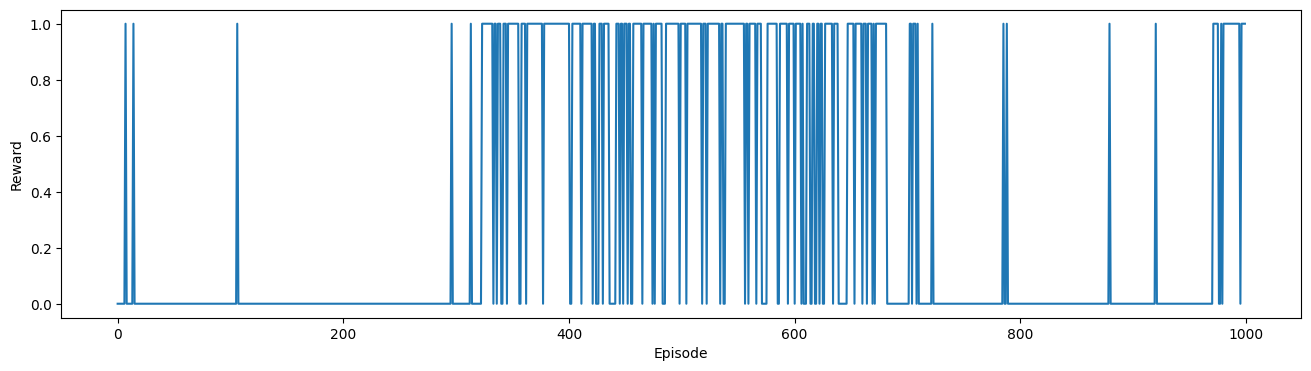

In [22]:
# Plot of the rewards

plt.figure(figsize=(16,4))
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

In [25]:
os.environ['SDL_VIDEODRIVER']='dummy'

In [29]:
# Video visualization
os.makedirs("video", exist_ok=True)

def show_video():
    mp4list = glob.glob('video/example.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[-1]  # Display the most recent video
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

env = gym.make('FrozenLake-v1', is_slippery=False)

state = env.reset()
done = False
vid = video_recorder.VideoRecorder(env, path="video/example.mp4")

while not done:
    env.render()

    action = agent.get_action(state)  # Get action from agent

    next_state, reward, done, info = env.step(action)
    vid.capture_frame()
    state = next_state

vid.close()
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

In [30]:
show_video()